This notebook generates a log increasing sine sweep with a certain amount of distortion harmonics.

In [1]:
%matplotlib inline

from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, mlab
from IPython.display import Audio
from scipy.io import wavfile
from math import log, floor, pi

import seaborn as sns

sns.set(context="notebook",
        style="whitegrid",
        color_codes=True,
        rc={'figure.figsize': (10, 8)})

In [2]:
def specgram(x, *args, **kwargs):
    sp, frq, t = mlab.specgram(x, *args, **kwargs)
    return 10 * np.log10(sp), frq, t

def specshow(x, frq=None, t=None, ax=None, cb=False, nfft=128, overlap=32, **kwargs):
    p = ax if ax else plt
    
    if np.sum(x.shape) == np.max(x.shape):
        im, frq_, t_ = specgram(x, NFFT=nfft, noverlap=overlap)
    else:
        im = x
    
    frq = frq_ if frq is None else frq
    t = t_ if t is None else t
    
    m = p.imshow(im, extent=(t[0], t[-1], frq[0], frq[-1]),
                 aspect='auto', origin='lower', **kwargs)
    
    if cb:
        plt.colorbar(m, aspect=10, ax=ax)
    
    return im, frq, t

In [3]:
def make_sweep(start, stop, rate=16000, sec=1.0, dc=0, ramp=0.1):
    size = int(sec*rate)
    signal = np.zeros((size,))
    
    freq = np.exp(np.linspace(log(start), log(stop), size))
    
    # no samples above nyquist frequency
    nyq = (log(rate/2)-log(start)) / (log(stop)-log(start))
    size = min(floor(nyq*size), size)
    
    # start/stop ramps
    amp = np.ones((size,))
    amp[0 : size//10] *= np.linspace(0, 1.0, size//10)
    amp[-(size//10):] *= np.linspace(1.0, 0, size//10)
    
    phase = np.zeros(size)

    for i in range(1, phase.size):
        phase[i] = phase[i-1] + 2.0*pi*freq[i]/rate

    signal[0:size] = amp*np.sin(phase) + dc
        
    return freq, signal

In [4]:
rate = 16000
sec = 1.0
start = 30
stop = 7500
num_partial = 3

size = int(sec*rate)
base = np.zeros(size)
partial = np.zeros((num_partial, size))
freq = np.zeros((num_partial, size))

low = np.arange(1, num_partial+1) * start
high = np.arange(1, num_partial+1) * stop

for i, lo, hi in zip(range(0, num_partial), low, high):
    freq[i], partial[i] = make_sweep(lo, hi, rate, sec)

base = np.sum(partial, axis=0)
base /= np.max(np.abs(base))

Audio((base * (2**15)).astype(np.int16), rate=rate)

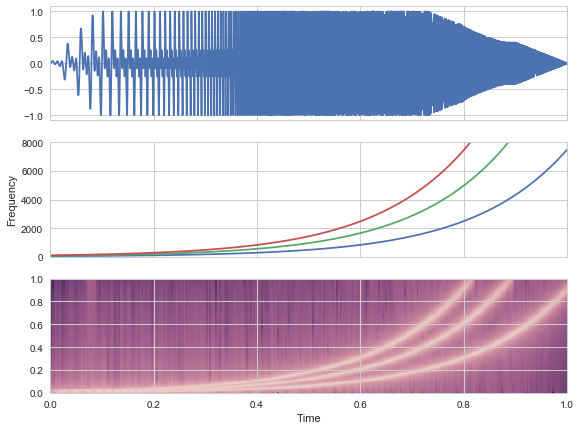

In [25]:
x = np.linspace(0, sec, int(sec*rate))

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
fig.tight_layout()

ax[0].plot(x, base)

ax[1].plot(x, freq.T)
ax[1].set_ylim(0, rate/2)
ax[1].set_ylabel('Frequency')

specshow(base, ax=ax[2], nfft=256, overlap=200, t=x, cmap=sns.cubehelix_palette(reverse=True, as_cmap=True))
ax[2].set_xlabel('Time');